In [1]:
import torch
import numpy as np
from PIL import Image
from matplotlib import pyplot as plt
from huggingface_mae import MAEModel
from skimage.transform import resize
from mae_utils import unflatten_tokens

/Users/kian.kd/.pyenv/versions/3.10.0/envs/fm/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/kian.kd/.pyenv/versions/3.10.0/envs/fm/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <9A4710B9-0DA3-36BB-9129-645F282E64B2> /Users/kian.kd/.pyenv/versions/3.10.0/envs/fm/lib/python3.10/site-packages/torchvision/image.so
  Expected in:     <F19B5356-08DC-327C-8EE1-6C5127508CD0> /Users/kian.kd/.pyenv/versions/3.10.0/envs/fm/lib/python3.10/site-packages/torch/lib/libtorch_cpu.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
/Users/kian.kd/.pyenv/versions/3.10.0/envs/fm/lib/python3.10/site-packages/torchvision/datapoints/__init_

In [2]:
channels = []
for i in range(1, 7):
    im = Image.open(f"sample/AA41_s1_{i}.jp2")
    channels.append(np.array(im))

image_array = np.stack(channels, axis=0)
print(image_array.shape)

image_tensor = torch.tensor(image_array)

(6, 512, 512)


In [3]:
# silly = Image.open("kian-headshot.png")
# image_array = resize(np.array(silly), (256, 256))
# image_tensor = torch.tensor(image_array).transpose(0, 2).transpose(1, 2)
# image_tensor = torch.concat([image_tensor, image_tensor], dim=0)
# image_tensor.shape

In [4]:
self_standardize = torch.nn.InstanceNorm2d(None, affine=False)

Original image - channel 0:


/Users/kian.kd/.pyenv/versions/3.10.0/envs/fm/lib/python3.10/site-packages/torch/nn/modules/instancenorm.py:80: UserWarning: input's size at dim=0 does not match num_features. You can silence this warning by not passing in num_features, which is not used because affine=False
  warnings.warn(f"input's size at dim={feature_dim} does not match num_features. "


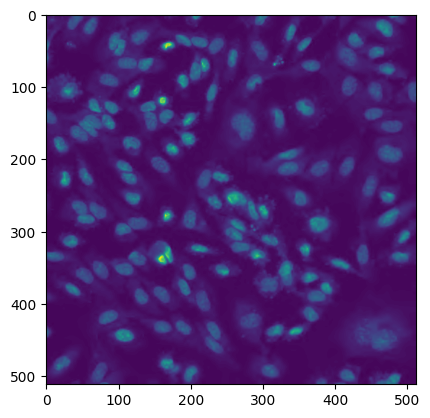

Original image - channel 1:


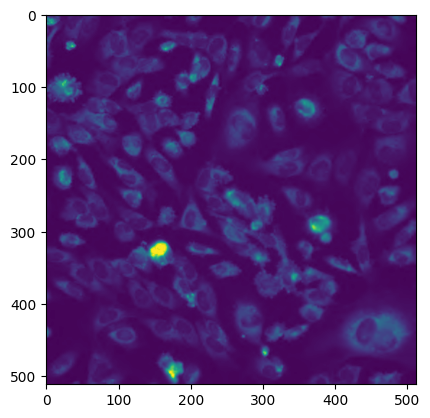

Original image - channel 2:


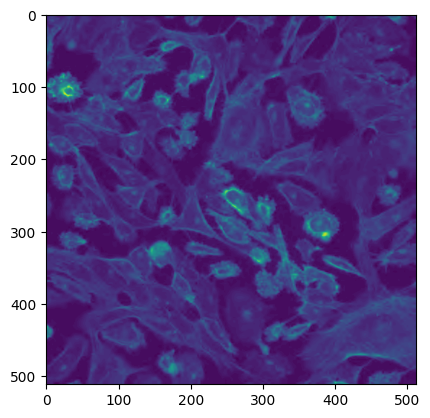

Original image - channel 3:


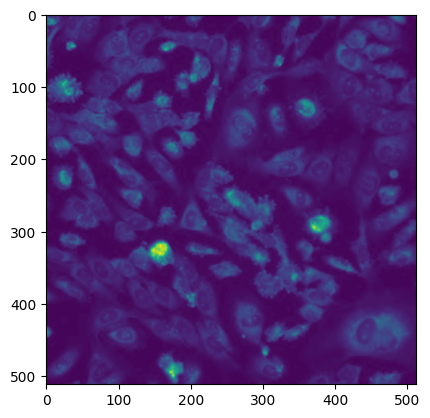

Original image - channel 4:


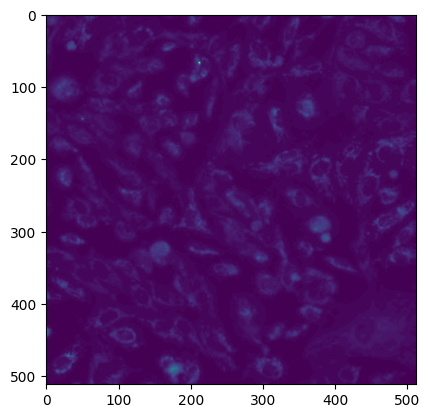

Original image - channel 5:


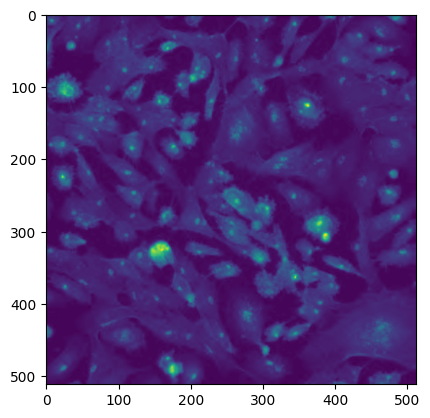

In [5]:
for i in range(6):
    print(f"Original image - channel {i}:")
    plt.imshow(self_standardize(image_tensor.float() / 255).numpy()[i], cmap="viridis")
    plt.show()

In [6]:
huggingface_phenombeta_model_dir = "models/phenom_beta_huggingface"
huggingface_model = MAEModel.from_pretrained(huggingface_phenombeta_model_dir)
huggingface_model = huggingface_model.eval()
huggingface_model.mask_ratio = 0.75  # for example visualization

In [7]:
def cropify(im):
    assert im.shape == (6, 512, 512)
    img = im.view(1, 6, 2, 256, 2, 256)
    img = img.permute(0, 2, 4, 1, 3, 5) 
    return img.reshape(-1, 6, 256, 256)

with torch.inference_mode():
    x = cropify(image_tensor) if image_tensor.shape[1] == 512 else image_tensor.unsqueeze(0)
    latent, reconstruction, mask = huggingface_model(x)

/Users/kian.kd/.pyenv/versions/3.10.0/envs/fm/lib/python3.10/site-packages/torch/nn/modules/instancenorm.py:80: UserWarning: input's size at dim=1 does not match num_features. You can silence this warning by not passing in num_features, which is not used because affine=False
  warnings.warn(f"input's size at dim={feature_dim} does not match num_features. "


In [8]:
selfstandardizer = torch.nn.modules.InstanceNorm2d(num_features=6, affine=False, track_running_stats=False)


def rescale_intensity(arr: torch.Tensor, bounds=(0.5, 99.5), out_range=(0.0, 1.0)) -> torch.Tensor:
    arr = arr.float() / 255
    sample = arr.flatten()[::100]
    percentiles = torch.quantile(sample, torch.tensor([bounds[0]/100.0, bounds[1]/100.0]))
    arr = torch.clamp(arr, percentiles[0], percentiles[1])
    arr = (arr - percentiles[0]) / (percentiles[1] - percentiles[0])
    arr = arr * (out_range[1] - out_range[0]) + out_range[0]
    return arr


def to_rgb(img: torch.Tensor, dtype=torch.float32) -> torch.Tensor:  # type: ignore[no-untyped-def]
    """Converts a typical photosynthetic image into RGB, assuming the 6-channel cellpaint standard.
    NOTE: to run on CUDA, use the float16 dtype (default assumption); to run on CPU, requires float32."""
    num_channels_required = 6
    b, num_channels, length, width = img.shape  # b x c x l x w
    prepped_img = torch.zeros(b, num_channels_required, length, width, dtype=img.dtype, device=img.device)
    if num_channels < num_channels_required:
        prepped_img[:, :num_channels, :, :] += img
    elif num_channels > num_channels_required:
        prepped_img += img[:, :num_channels_required, :, :]
    else:
        prepped_img += img
    # color mapping
    red = [1, 0, 0]
    green = [0, 1, 0]
    blue = [0, 0, 1]
    yellow = [1, 1, 0]
    magenta = [1, 0, 1]
    cyan = [0, 1, 1]
    rgb_map = torch.tensor([blue, green, red, cyan, magenta, yellow], dtype=dtype, device=prepped_img.device)
    rgb_img: torch.FloatTensor = (
        torch.einsum(  # type: ignore[assignment]
            "nchw,ct->nthw",
            prepped_img.to(dtype=dtype),
            rgb_map,
        )
        / 3.0
    )
    _max = rgb_img.max().item()
    _min = rgb_img.min().item()
    return rescale_intensity(rgb_img, bounds=(0.1, 99.9))
    # return rgb_img

In [9]:
crop_size = 256
patch_size = 16

m_r = mask.cpu().numpy()[0]
m_r.shape

(1536,)

In [10]:
# lets just look at top left corner
z = image_tensor.cpu().numpy()[:, :crop_size, :crop_size]

In [11]:
r = selfstandardizer(unflatten_tokens(reconstruction.cpu(), patch_size=16, num_modalities=6, channel_agnostic=True))[0]
r.shape

torch.Size([6, 256, 256])

/var/folders/rh/2pzrb9394871v5556j113wwh0000gr/T/ipykernel_30873/1741124146.py:22: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


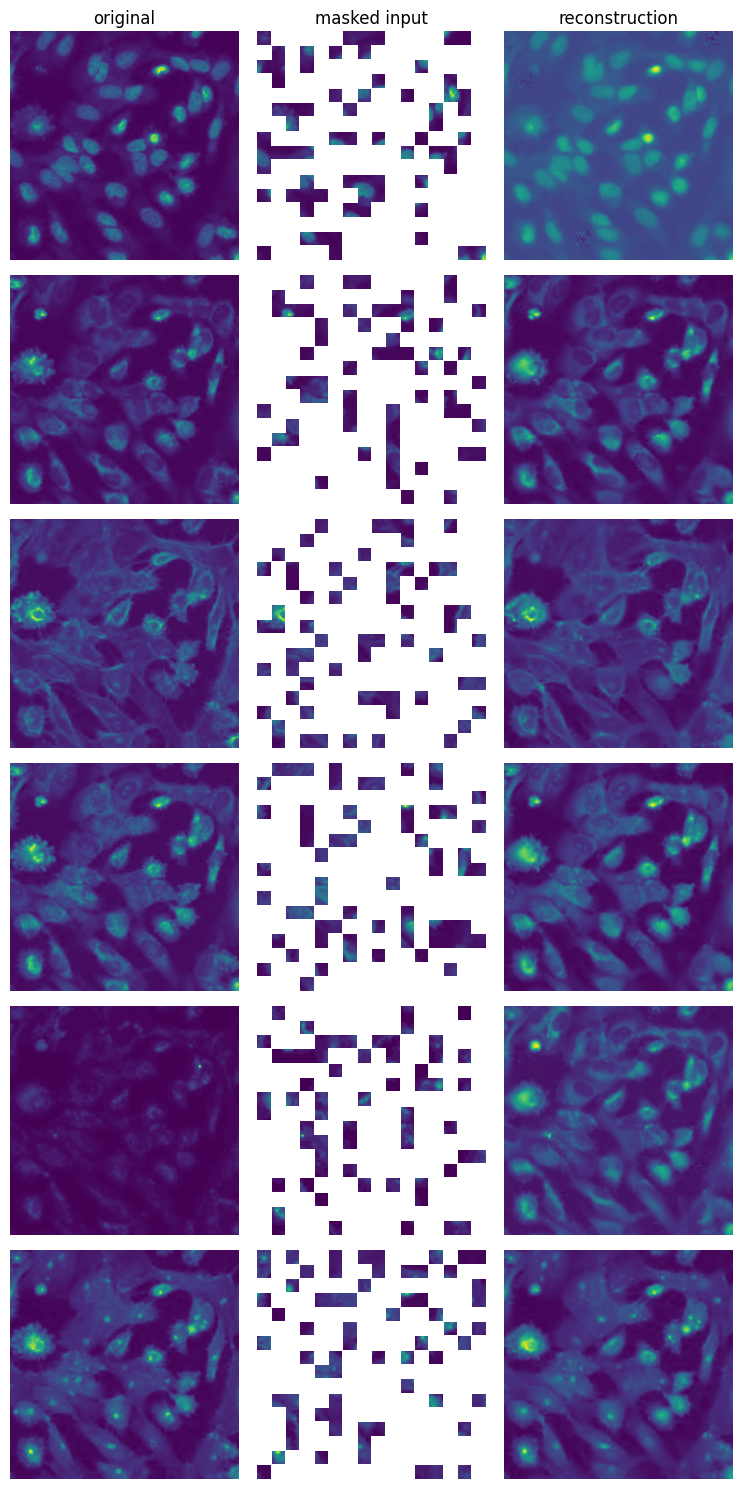

In [12]:
plt.figure(figsize=(12.5,15))
for chan in range(6):
    cmap = 'gray'
    plt.subplot(6,5,1+chan*5)
    plt.imshow(z[chan]);plt.axis('off')
    if chan==0:
        plt.title('original')
        
    plt.subplot(6,5,2+chan*5)
    channel_mask = m_r[chan * patch_size ** 2: (chan + 1) * patch_size ** 2]
    channel_mask = channel_mask.reshape(crop_size//patch_size, crop_size//patch_size)
    channel_mask = resize(channel_mask==1,(crop_size,crop_size))
    plt.imshow(np.ma.masked_where(channel_mask, z[chan]));plt.axis('off')
    if chan==0:
        plt.title('masked input')
        
    plt.subplot(6,5,3+chan*5)
    plt.imshow(r[chan]);plt.axis('off')
    if chan==0:
        plt.title('reconstruction')
        
    plt.tight_layout()



ORIGINAL (rgb)


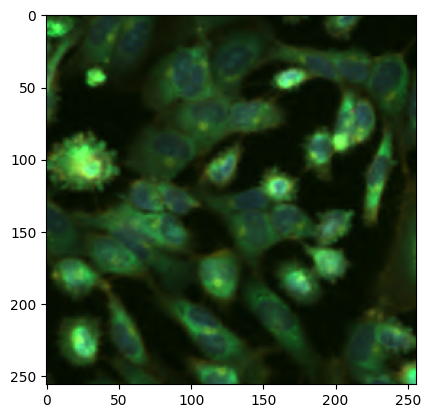

In [13]:
print("ORIGINAL (rgb)")
_ = plt.imshow(to_rgb(torch.tensor(z).unsqueeze(0)).squeeze().transpose(2,0).transpose(0,1))

RECONSTRUCTED (rgb)
torch.Size([4, 3, 256, 256])


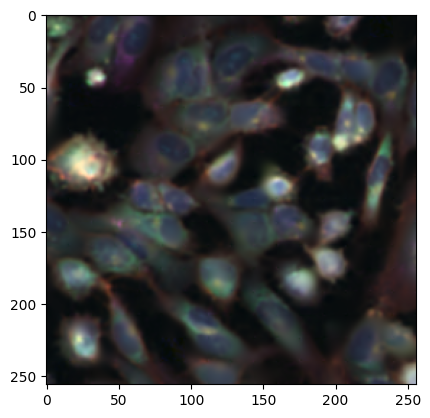

In [14]:
print("RECONSTRUCTED (rgb)")
# def visualize_crop(bf_input_crop, bf_reconstruction_crop, cp_reconstruction_crop):
cp_rgb = to_rgb(
    selfstandardizer(
        unflatten_tokens(reconstruction.cpu(), patch_size=16, num_modalities=6, channel_agnostic=True)
    )
).cpu().squeeze()
print(cp_rgb.shape)
if len(cp_rgb.shape) == 4:
    cp_rgb = cp_rgb[0]
_ = plt.imshow(cp_rgb.transpose(2,0).transpose(0,1))